# Paso 1: Importar librerías necesarias

In [49]:
import pandas as pd
from pycaret.regression import *
pd.set_option('display.float_format', '{:,.2f}'.format)  # Opcional: para mostrar floats con 2 decimales

# Paso 2: Descargar y explorar los datos

In [50]:
# Descargar los datos historicos del API
# url = "https://e995-191-156-244-30.ngrok-free.app/colfe_web/api/apiTotalLiquidacion.php"
url = "http://localhost:82/colfe_web/api/apiTotalLiquidacion.php"
df = pd.read_json(url)

# (Opcional) Ver las primeras filas para explorar
print(df.head())

  vinculacion quincena fecha_liquidacion  total_litros     total_neto
0    asociado      1ra        2024-01-15     23,617.68  38,903,930.62
1   proveedor      1ra        2024-01-15     71,314.99 116,787,210.59
2    asociado      2da        2024-01-31     25,017.03  41,264,983.90
3   proveedor      2da        2024-01-31     76,249.22 124,867,628.93
4    asociado      1ra        2024-02-15     23,474.33  38,662,063.33


# Paso 3: Filtrar solo proveedores

In [51]:
df_proveedor = df[df['vinculacion'] == 'proveedor'].copy()

# Paso 4: Identificar la última quincena liquidada

In [52]:
# Obtener la fecha de la última quincena liquidada
ultima = df_proveedor['fecha_liquidacion'].max()
row_ultima = df_proveedor[df_proveedor['fecha_liquidacion'] == ultima].iloc[0]
anio_mes = pd.to_datetime(row_ultima['fecha_liquidacion']).strftime('%Y-%m')

# Paso 5: Determinar la siguiente quincena y el mes/año correspondiente

In [53]:
if row_ultima['quincena'] == '1ra':
    siguiente_quincena = '2da'
    siguiente_anio_mes = anio_mes
else:
    siguiente_quincena = '1ra'
    # Avanzar al siguiente mes
    siguiente_anio_mes = (pd.to_datetime(row_ultima['fecha_liquidacion']) + pd.DateOffset(months=1)).strftime('%Y-%m')

print(f"Siguiente quincena a predecir: {siguiente_quincena} de {siguiente_anio_mes}")

Siguiente quincena a predecir: 1ra de 2025-06


# Paso 6: Entrenar SOLO con quincenas ya liquidadas

In [54]:
# Excluir la última quincena liquidada para evitar fuga de datos
df_historico = df_proveedor[df_proveedor['fecha_liquidacion'] < ultima]

# Seleccionar solo las columnas relevantes para el modelo
df_modelo = df_historico[['quincena', 'total_litros', 'total_neto']]

# Paso 7: Configurar y entrenar PyCaret

In [55]:
reg1 = setup(
    data=df_modelo,
    target='total_neto',
    session_id=123,      # Para reproducibilidad
    normalize=True       # Normaliza los datos numéricos
)

,Description,Value
0,Session id,123
1,Target,total_neto
2,Target type,Regression
3,Original data shape,"(33, 3)"
4,Transformed data shape,"(33, 3)"
5,Transformed train set shape,"(23, 3)"
6,Transformed test set shape,"(10, 3)"
7,Numeric features,1
8,Categorical features,1
9,Preprocess,True


# Paso 8: Comparar y seleccionar los mejores modelos

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,4.3600,28.1444,4.8228,1.0000,0.0000,0.0000,1.0600
lasso,Lasso Regression,29.0160,6393.0866,29.9468,1.0000,0.0000,0.0000,0.3080
lar,Least Angle Regression,4.3600,28.1444,4.8228,1.0000,0.0000,0.0000,0.0160
llar,Lasso Least Angle Regression,4.0832,27.0231,4.6577,1.0000,0.0000,0.0000,0.0150
omp,Orthogonal Matching Pursuit,4.2469,26.2729,4.6335,1.0000,0.0000,0.0000,0.0150
et,Extra Trees Regressor,835681.5213,9919785137050.8086,1066396.0135,-5.5644,0.0096,0.0079,0.0410
catboost,CatBoost Regressor,1822558.0951,15430261637279.3223,2328862.3074,-19.9781,0.0194,0.0154,0.2370
gbr,Gradient Boosting Regressor,1015464.1325,10567059196678.1602,1312793.1885,-21.3403,0.0117,0.0095,0.0390
dt,Decision Tree Regressor,838365.2000,9914324917415.4668,1071062.6852,-21.3874,0.0097,0.0079,0.0140
xgboost,Extreme Gradient Boosting,2880248.6834,33274640327692.8008,3599097.0727,-21.7723,0.0293,0.0231,0.0390


Mejor modelo seleccionado:
LinearRegression(n_jobs=-1)


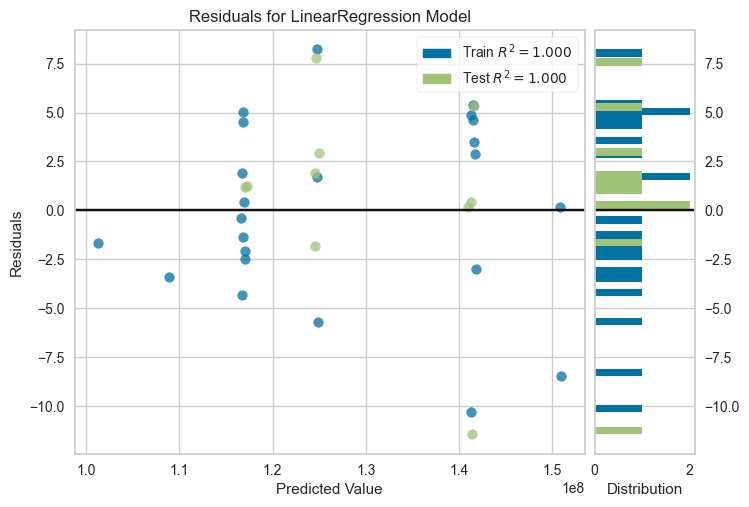

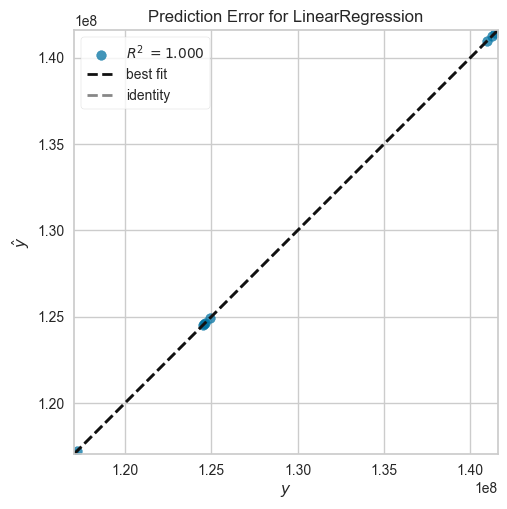

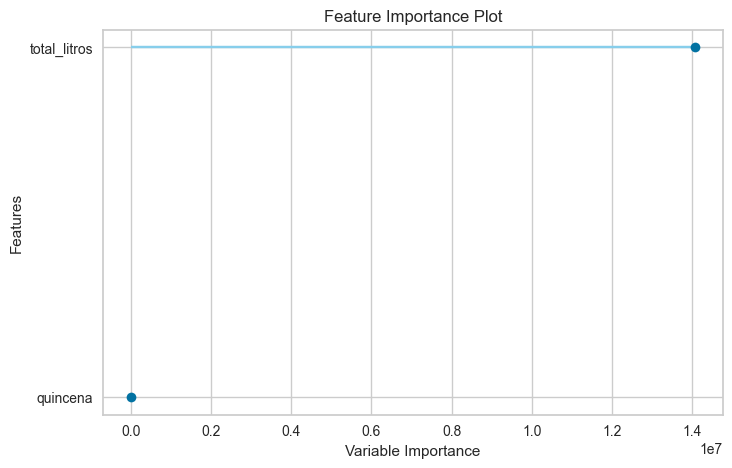

                                    Model            MAE  \
lr                      Linear Regression           4.36   
lasso                    Lasso Regression          29.02   
lar                Least Angle Regression           4.36   
llar         Lasso Least Angle Regression           4.08   
omp           Orthogonal Matching Pursuit           4.25   
et                  Extra Trees Regressor     835,681.52   
catboost               CatBoost Regressor   1,822,558.10   
gbr           Gradient Boosting Regressor   1,015,464.13   
dt                Decision Tree Regressor     838,365.20   
xgboost         Extreme Gradient Boosting   2,880,248.68   
rf                Random Forest Regressor   1,569,981.33   
ada                    AdaBoost Regressor     895,222.45   
ridge                    Ridge Regression     654,689.88   
knn                 K Neighbors Regressor   4,587,875.04   
en                            Elastic Net   4,554,180.77   
huber                     Huber Regresso

In [58]:
top5 = compare_models(n_select=5)
print("Mejor modelo seleccionado:")

print(top5[0])
# Visualizar los residuos
plot_model(top5[0], plot='residuals')

# Visualizar el error
plot_model(top5[0], plot='error')

# Visualizar la importancia de las variables
plot_model(top5[0], plot='feature')

# Después de compare_models
resultados = pull()
print(resultados)


# Paso 9: Guardar el mejor modelo

In [57]:
save_model(top5[0], 'modelo_liquidacion')
print("Modelo guardado exitosamente.")

Transformation Pipeline and Model Successfully Saved
Modelo guardado exitosamente.


## **Resumen del flujo**

1. **Descargas y filtras los datos históricos**.
2. **Identificas la última quincena liquidada** (para no usarla en el entrenamiento).
3. **Entrenas el modelo solo con datos históricos previos**.
4. **Guardas el mejor modelo** para usarlo luego en predicciones.
